# 🔄 Keras conversion and training

In this example, a simple `serket` model is converted and trained in the new `keras` with the `jax` backend.

In [ ]:
!pip install git+https://github.com/ASEM000/serket --quiet
!pip install keras_core --quiet

### Imports

In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"
import jax.numpy as jnp
import jax.random as jr
import keras_core as keras
from keras_core import Variable
import serket as sk
import jax
import matplotlib.pyplot as plt

Using JAX backend.


### Conversion layer

In [2]:
# define a keras layer that wraps the serket layer
class Serket2Keras(keras.Layer):
    def __init__(self, layer, name=None):
        """Converts a serket layer to a keras layer"""
        super().__init__(name=name)
        # extract the leaves from the serket layer
        # here leaves of a masked layer are the trainable variables
        # and treedef is the tree structure of the layer
        leaves, treedef = jax.tree_util.tree_flatten(sk.tree_mask(layer))
        self.treedef = treedef
        for leaf in leaves:
            # create a keras variable for each leaf
            variable = Variable(initializer=leaf, trainable=not sk.is_nondiff(leaf))
            variable._value = leaf
            # add the variable to the keras layer so it can be tracked
            self._track_variable(variable)
        # mark the layer as built
        self.built = True

    def call(self, x):
        """Applies the layer to the input"""
        # convert the keras variables to jax arrays to be used in serket
        leaves = jax.tree_map(jnp.array, self.trainable_variables)
        # unflatten the layer with the updated leaves
        layer = jax.tree_util.tree_unflatten(self.treedef, leaves)
        # apply the layer after unmasking it
        return sk.tree_unmask(layer)(x)

    def to_serket(self):
        """Converts the keras layer to a serket layer"""
        leaves = jax.tree_map(jnp.array, self.trainable_variables)
        layer = jax.tree_util.tree_unflatten(self.treedef, leaves)
        return sk.tree_unmask(layer)

### Define a simple `serket` layer

In [3]:
# lets define a simple model in serket
class Linear(sk.TreeClass):
    def __init__(self, in_features, out_features, *, key):
        k1, k2 = jr.split(key)
        self.in_features = in_features
        self.out_features = out_features
        self.weight = jr.normal(k1, (in_features, out_features))
        self.bias = jr.normal(k2, (out_features,))

    def __call__(self, x):
        return x @ self.weight + self.bias

### Train in `keras`

In [4]:
sk_model = sk.nn.Sequential(
    Linear(1, 20, key=jr.PRNGKey(0)),
    jax.nn.tanh,
    Linear(20, 1, key=jr.PRNGKey(1)),
)

model = keras.Sequential([Serket2Keras(sk_model, name="serket")])


model.compile(
    optimizer=keras.optimizers.Adam(1e-2),
    loss=keras.losses.MeanSquaredError(),
)

x = jnp.linspace(-1, 1, 100)[:, None]
y = x**2 + jr.normal(jr.PRNGKey(0), (100, 1)) * 0.01
model.fit(x, y, epochs=100)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1.1592
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 0.1850
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 0.0842
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 0.1691
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 0.1256
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0547
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0379
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 0.0353
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0334
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0253
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0053
Epoch 16/100
4/4 ━━━━━━

### Extract trained layer

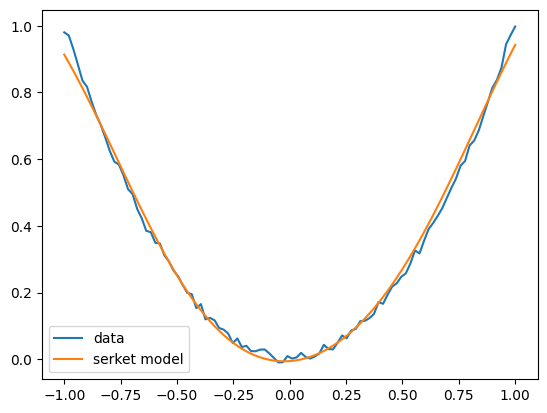

In [5]:
# take the serket layer from the keras layer at the end
sk_model = model.layers[0].to_serket()

plt.plot(x, y, label="data")
plt.plot(x, sk_model(x), label="serket model")
plt.legend()